In [1]:
# 获取MNIST数据集
import torch
if torch.cuda.is_available(): # 如果有可用的cuda设备，则设置为cuda
    device = 'cuda'
else: # 否则用cpu
    device = 'cpu'

import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((32, 32)),  # 变形为LeNet所需的输入形状(32 ×32)
    transforms.ToTensor(),  # 转换为tensor（注意，此处的tensor默认在CPU上储存）
    torchvision.transforms.Normalize((0.1307, ), (0.3081, )) # MNIST数据集标准化
])

## 获得训练数据的Dataset
trainset = torchvision.datasets.MNIST(root='../dataset', train=True, download=True, transform=transform)
## 获得验证数据的Dataset
testset = torchvision.datasets.MNIST(root='../dataset', train=False, download=True, transform=transform)

In [2]:
# 构建数据读取器
batch_size = 128   # 设置一次读入128个数据
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)  # 训练集进行打乱
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)  # 测试集不进行打乱

torch.Size([128, 1, 32, 32])
torch.Size([128])


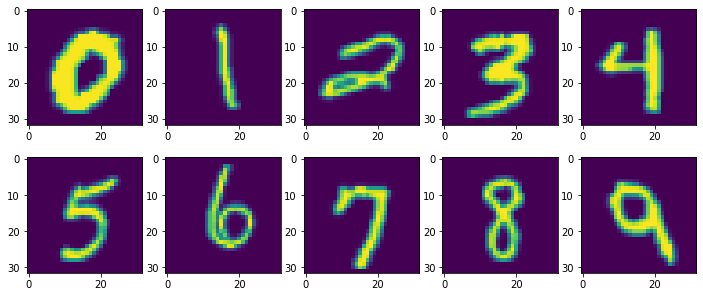

In [3]:
# 数据读取器图片展示
from matplotlib import pyplot as plt
from torchvision.utils import make_grid
images, labels = next(iter(trainloader))  # 获取训练集第一个批次中的图片及相应标签
print(images.shape)   # 打印图片的尺寸128，图片本身为1*32*32（1表示只有一个channel），由于batch_size为128，因此整合为128*1*32*32
print(labels.shape)   # 打印标签的尺寸128，标签本身是一维，由于batch_size为128.因此整合为128

fig,ax = plt.subplots(2, 5, figsize=(12, 5)) # 设置画布大小，创建2行5列的子图
ax = ax.flatten()   # 将多维数组“压平”为一维数组，可直接使用a[i]访问子图，不须再使用a[i][j]
for i in range(10):
    im = images[labels==i][0].reshape(32, 32)
    ax[i].imshow(im)
plt.show()   # 展示图片

In [4]:
# 构建LeNet-5模型
import torch.nn as nn
import torch.nn.functional as F

# 定义LeNet-5网络
class LeNet(nn.Module):
    '''
    为定义LeNet-5模型，需要继承nn.Module类，该类需要定义两个函数。
    1. __init__：初始化，这里采用nn.Sequential建立卷积神经网络
    2. forward(self,x)：定义前馈学习，x为输入的像素矩阵
    '''
    def __init__(self):
        super(LeNet, self).__init__() # 直接继承nn.Module的构造方法
        ## 构建卷积层
        self.conv = nn.Sequential(    # 通过 nn.Sequential 容器将网络按顺序组合在一起
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0),
            # 第一个卷积层，输入为1维，输出为6维，卷积核的尺寸为5*5，步长为1，不填充
            # （32-5）/1+1=28  输出为6*28*28
            nn.ReLU(),   # 使用ReLU作为激活函数。ReLU 函数将所有负值转换为 0，而正值保持不变
            nn.MaxPool2d(kernel_size=2, stride=2),   # 池化核的大小和步长都是 2x2，处理后数据维度变为6*14*14
            nn.Conv2d(6, 16, 5),  # 第二个卷积层，输入为6维，输出为16维，卷积核的尺寸为5*5，步长为1，不填充 ，输出为16*10*10
            nn.ReLU(),   # 依然使用ReLU作为激活函数
            nn.MaxPool2d(2, 2)  # 池化层 输出为16*5*5
        )
        ## 构建全连接层
        self.fc = nn.Sequential(
            nn.Linear(16 * 5 * 5, 200), # 16*5*5为卷积层的输出维数, 200为第一个全连接层的输出节点个数
            nn.ReLU(),  # 使用ReLU作为激活函数
            nn.Linear(200, 80),  # 全连接层，输入为200维，输出为80维
            nn.ReLU(),  # 使用ReLU作为激活函数
            nn.Linear(80, 20)  # 全连接层，输入为80维，输出为20维
        ) # 注意这里只进行了线性变换，没有接softmax变换，这是因为随后的损失函数中包含了softmax操作。

    def forward(self, x):
        feature = self.conv(x)  # 将输入x通过卷积层得到特征图 
        output = self.fc(feature.view(x.size()[0], -1))  # 在卷积操作后，输出仍是tensor，需要进行flatten拉直再输入进全连接层
        return output
        
model = LeNet() # 实例化一个Lenet模型
model.to(device)  # 将模型中所有参数tensor切换到GPU存储模式

## 查看模型具体信息
from torchsummary import summary  # 需要预先下载，在终端输入 pip install torchsummary
IMSIZE = 32
summary(model, (1, 32, 32)) # 给定模型和输入shape，统计参数信息

# 6*（5*5*1+1）=156
# 16*（5*5*6+1）=2416
# 200*（16*5*5+1）=80200
# 80*（200+1）=16080
# 20*（80+1)=1620

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              ReLU-2            [-1, 6, 28, 28]               0
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         MaxPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 200]          80,200
              ReLU-8                  [-1, 200]               0
            Linear-9                   [-1, 80]          16,080
             ReLU-10                   [-1, 80]               0
           Linear-11                   [-1, 20]           1,620
Total params: 100,472
Trainable params: 100,472
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [5]:
# 训练、验证Lenet模型
# 首先定义几个训练中会用到的函数
# 计算模型预测准确率
def accuracy(outputs, labels):
    preds = torch.max(outputs, dim=1)[1]  # 获取预测类别
    return torch.sum(preds == labels).item() / len(preds)  # 计算准确率

# 模型验证
def validate(model, testloader):
    val_loss = 0  # 初始化loss
    val_acc = 0   # 初始化acc
    model.eval() # 给网络做标记，标志着模型在测试集上训练
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)  # 将tensor切换到GPU存储模式
        outputs = model(inputs)  # 计算模型输出
        loss = F.cross_entropy(outputs, labels)  # 计算交叉熵损失函数
        val_loss += loss.item()  # item方法提取出tensor中的数字
        acc = accuracy(outputs, labels)  # 计算准确率
        val_acc += acc  # 累加测试集准确率
    val_loss /= len(testloader)  # 计算平均损失
    val_acc /= len(testloader)  # 计算平均准确率
    return val_loss, val_acc

# 打印训练结果
def print_log(epoch, train_time, train_loss, train_acc, val_loss, val_acc):
    print(f"Epoch [{epoch}/{epochs}], time: {train_time:.2f}s, loss: {train_loss:.4f}, acc: {train_acc:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}")

import time
# 定义主函数：模型训练
def train(model, trainloader, testloader, epochs=1, lr=1e-3):
    # 定义存储训练集和测试集上损失和准确率的容器
    train_losses = []; train_accs = []   # 初始化训练集loss与acc
    val_losses = []; val_accs = []      # 初始化测试集loss与acc
    model.train() # 给网络做标记，标志着模型在训练集上训练
    for epoch in range(epochs):   # 对于每一轮全样本训练
        train_loss = 0    # 初始化loss
        train_acc = 0     # 初始化acc
        start = time.time()  # 记录本epoch开始时间
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)  # 将tensor切换到GPU存储模式
            optimizer.zero_grad()  # 将模型所有参数tensor的梯度变为0（否则之后计算的梯度会与先前存在的梯度叠加）
            outputs = model(inputs)  # 计算模型输出
            loss = F.cross_entropy(outputs, labels)  # 计算交叉熵损失函数
            train_loss += loss.item()  # item方法提取出tensor中的数字
            acc = accuracy(outputs, labels)  # 计算准确率
            train_acc += acc   # 累加训练集准确率
            loss.backward()  # 调用PyTorch的autograd自动求导功能，计算loss相对于模型各参数的导数
            optimizer.step()  # 根据模型中各参数相对于loss的导数，以及指定的学习率，更新参数
        end = time.time()  # 记录本epoch结束时间
        train_time = end - start  # 计算本epoch的训练耗时
        train_loss /= len(trainloader)  # 计算平均损失
        train_acc /= len(trainloader)  # 计算平均准确率
        val_loss, val_acc = validate(model, testloader)  # 计算测试集上的损失函数和准确率
        train_losses.append(train_loss); train_accs.append(train_acc)  # 将loss和acc添加入列表
        val_losses.append(val_loss); val_accs.append(val_acc)    # 将loss和acc添加入列表
        print_log(epoch + 1, train_time, train_loss, train_acc, val_loss, val_acc)  # 打印训练结果
    return train_losses, train_accs, val_losses, val_accs

# 给定超参数，定义优化器，进行模型训练
epochs = 50  # 训练周期数
lr = 1e-3  # 学习率
optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # 设置优化器
train_losses, train_accs, val_losses, val_accs = train(model, trainloader, testloader, epochs=epochs, lr=lr)  # 实施训练

Epoch [1/50], time: 7.26s, loss: 0.3332, acc: 0.8973, val_loss: 0.0892, val_acc: 0.9736
Epoch [2/50], time: 6.96s, loss: 0.0845, acc: 0.9740, val_loss: 0.0542, val_acc: 0.9836
Epoch [3/50], time: 6.98s, loss: 0.0589, acc: 0.9819, val_loss: 0.0451, val_acc: 0.9855
Epoch [4/50], time: 7.22s, loss: 0.0448, acc: 0.9862, val_loss: 0.0418, val_acc: 0.9866
Epoch [5/50], time: 6.86s, loss: 0.0355, acc: 0.9887, val_loss: 0.0439, val_acc: 0.9857
Epoch [6/50], time: 7.11s, loss: 0.0313, acc: 0.9904, val_loss: 0.0330, val_acc: 0.9888
Epoch [7/50], time: 7.01s, loss: 0.0251, acc: 0.9922, val_loss: 0.0349, val_acc: 0.9884
Epoch [8/50], time: 7.22s, loss: 0.0232, acc: 0.9928, val_loss: 0.0422, val_acc: 0.9869
Epoch [9/50], time: 6.85s, loss: 0.0195, acc: 0.9938, val_loss: 0.0335, val_acc: 0.9903
Epoch [10/50], time: 6.90s, loss: 0.0160, acc: 0.9951, val_loss: 0.0329, val_acc: 0.9904
Epoch [11/50], time: 7.15s, loss: 0.0146, acc: 0.9950, val_loss: 0.0402, val_acc: 0.9884
Epoch [12/50], time: 6.90s, lo

Text(0, 0.5, 'test accuracy')

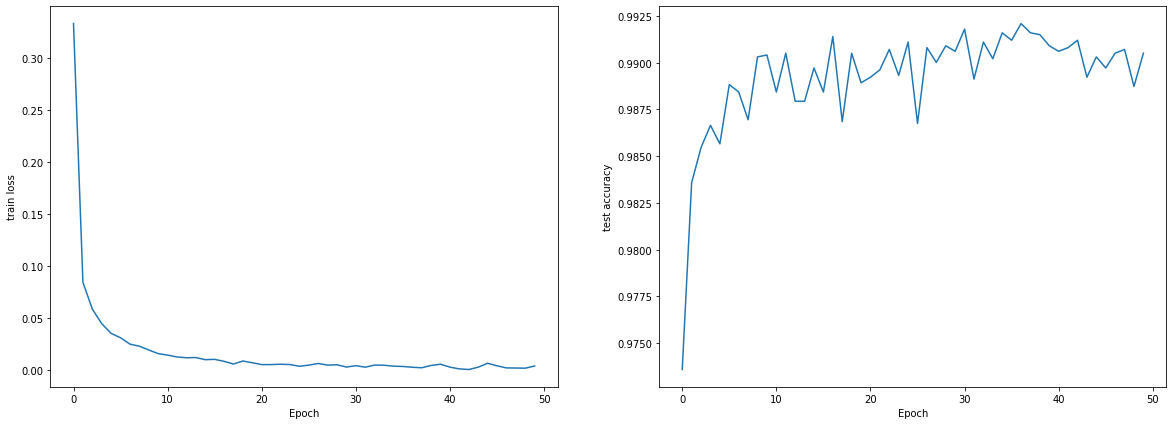

In [6]:
# 训练集的误差曲线和测试集的准确率曲线可视化
plt.figure(figsize=(20, 7))  # 创建一个新的图形窗口，并设置其大小为宽度20英寸和高度7英寸
plt.subplot(1, 2, 1)  # 创建一个1行2列的子图网格，并激活第1个子图
plt.plot(train_losses)   # 在第1个子图上绘制train_losses的数据
plt.xlabel("Epoch")  # 为第1个子图的x轴设置标签为“Epoch”
plt.ylabel("train loss")  # 为第1个子图的y轴设置标签为“train loss”
plt.subplot(1, 2, 2)  # 切换到第2个子图
plt.plot(val_accs)   # 在第2个子图上绘制val_accs的数据
plt.xlabel("Epoch")  # 为第2个子图的x轴设置标签为“Epoch”
plt.ylabel("test accuracy")  # 为第2个子图的y轴设置标签为“test accuracy”